## Sandbox for thesis code

In [1]:
# set path
import importlib
import sys, os
sys.path.append(os.path.abspath(".."))

import requests
import pandas as pd
import pickle as pkl

from src.auxilaries import retrieve_data_from_api

from sklearn.ensemble import RandomForestRegressor

Step 1: Import sample dataset from VIEWS to use for testing

In [2]:
api_url = "https://api.viewsforecasting.org"
loa = "cm"

fat_002_run = "predictors_fatalities002_2025_12"

And retrieve data for the full range.

In [24]:
fat_002_data = retrieve_data_from_api(fat_002_run, loa, verbose=True)

And save as pickle file

In [ ]:
with open("../data/raw/fat_002_data.pkl", "wb") as f:
    pkl.dump(fat_002_data, f)

## Test with basic random forest algorithm

In [3]:
with open("../data/raw/fat_002_data.pkl", "rb") as f:
    views_data = pkl.load(f)

In [4]:
views_data.columns

Index(['country_id', 'month_id', 'name', 'gwcode', 'isoab', 'year', 'month',
       'wb_wdi_sp_dyn_le00_in', 'wb_wdi_sp_dyn_imrt_in', 'wb_wdi_sp_pop_totl',
       'wb_wdi_se_prm_nenr', 'ucdp_ged_sb_best_sum', 'ucdp_ged_ns_best_sum',
       'vdem_v2x_rule', 'wb_wdi_ny_gdp_pcap_kd', 'ucdp_ged_os_best_sum',
       'vdem_v2x_libdem', 'vdem_v2x_gender', 'vdem_v2x_civlib',
       'vdem_v2xcl_acjst', 'vdem_v2xeg_eqdr'],
      dtype='str')

In [5]:
# make list of features
feature_list = [
   'wb_wdi_sp_dyn_le00_in', 'wb_wdi_sp_dyn_imrt_in', 'wb_wdi_sp_pop_totl',
    'ucdp_ged_sb_best_sum', 'ucdp_ged_ns_best_sum',
    'vdem_v2x_rule', 'wb_wdi_ny_gdp_pcap_kd', 'ucdp_ged_os_best_sum',
    'vdem_v2x_libdem', 'vdem_v2x_gender', 'vdem_v2x_civlib',
    'vdem_v2xcl_acjst', 'vdem_v2xeg_eqdr'
] 
target = "ucdp_ged_sb_best_sum"

## Test with Class structure

In [85]:
from src import dynamic
from src import auxilaries
importlib.reload(dynamic)
importlib.reload(auxilaries)
from src.auxilaries import date_to_month_id, month_id_to_ym
from src.dynamic import DynamicModel, DynamicModelManager

In [52]:
full_model = DynamicModelManager(
    steps = [1],
    data = views_data,
    features = feature_list,
    target = target,
    train_window_size=120,
    test_window_size=100,
    slide_window_size = 12,
    full_split = (121, 528)
)

In [53]:
full_model.fit()

Fitting models: 100%|██████████| 24/24 [01:16<00:00,  3.17s/it]

Finished fitting all models in 76.19 seconds


In [54]:
full_model.predict(data = views_data, test_window_size=12, slide_window_size=12)

Predicting: 100%|██████████| 552/552 [00:04<00:00, 128.16it/s]


In [55]:
actuals = views_data[["country_id", "month_id", "ucdp_ged_sb_best_sum"]]

In [56]:
rows = []

for prediction in full_model.predictions:
    row = {
        "train_start": prediction.train_split.start_month,
        "train_end": prediction.train_split.end_month,
        "train_step": prediction.train_split.step,
        "test_start": prediction.test_split.start_month,
        "test_end": prediction.test_split.end_month,
        "test_step": prediction.test_split.step,
        "mse": prediction.mse(actuals),
        "msle": prediction.msle(actuals),
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

In [57]:
metrics_df["distance"] = metrics_df.apply(lambda row: (row["train_end"] + row["train_start"]) / 2 - row["test_end"], axis=1)

In [59]:
metrics_df.sort_values("test_start").head(20)

,train_start,train_end,train_step,test_start,test_end,test_step,mse,msle,distance
551,398,517,1,122,133,1,163952.581117,0.966543,324.5
47,146,265,1,122,133,1,198549.054810,0.968540,72.5
431,338,457,1,122,133,1,138803.706858,0.966661,264.5
407,326,445,1,122,133,1,138630.035021,0.966762,252.5
479,362,481,1,122,133,1,138651.839780,0.966291,288.5
71,158,277,1,122,133,1,198141.096792,0.968476,84.5
383,314,433,1,122,133,1,138214.062573,0.966069,240.5
95,170,289,1,122,133,1,195887.202981,0.969056,96.5
359,302,421,1,122,133,1,138072.629768,0.966387,228.5
335,290,409,1,122,133,1,135034.222219,0.964759,216.5


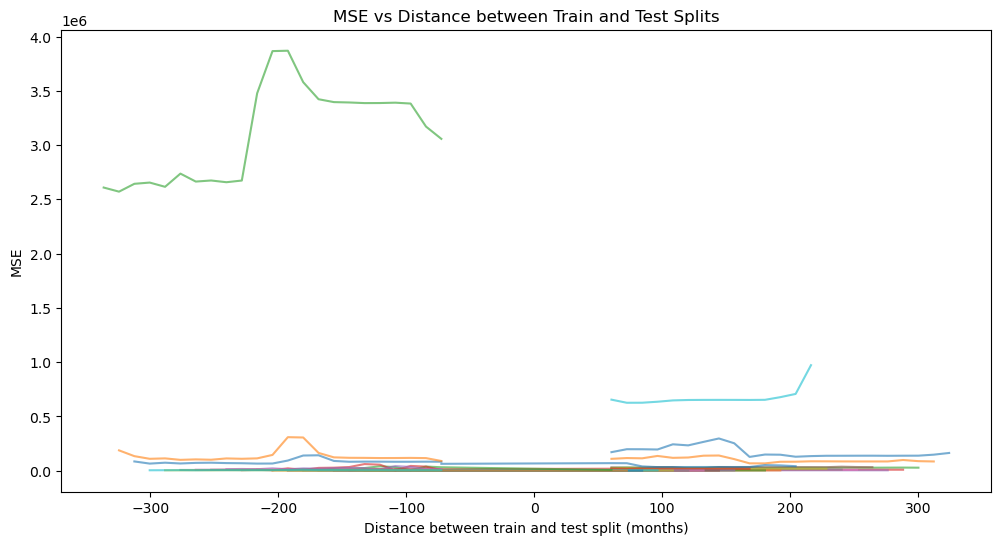

In [60]:
# plot mse and msle against distance, grouped by test_start
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for test_start, group in metrics_df.groupby("test_start"):
    plt.plot(group["distance"], group["mse"], label=f"test_start={test_start}", alpha=0.6)
plt.xlabel("Distance between train and test split (months)")
plt.ylabel("MSE")
plt.title("MSE vs Distance between Train and Test Splits")
#plt.legend()
plt.show()

## Test with better dataset and more features

Read in joint_narrow dataset from VIEWSER

In [73]:
fat_data = pd.read_parquet("../data/raw/fatalities002_joint_narrow.parquet")

In [74]:
fat_data.reset_index(inplace=True,)

Define features and target (predict for log target this time)

In [ ]:
fat_features = [
        'ln_ged_sb_dep', 'ln_ged_sb', 'reign_tenure_months',
       'wdi_sp_pop_totl', 'wdi_ag_lnd_frst_k2', 'wdi_nv_agr_totl_kn',
       'wdi_sh_sta_maln_zs', 'wdi_sl_tlf_totl_fe_zs', 'wdi_sm_pop_refg_or',
       'wdi_sp_dyn_imrt_in', 'wdi_sp_pop_14_fe_zs', 'wdi_sp_pop_grow',
       'vdem_v2xcl_dmove', 'vdem_v2xcl_rol', 'vdem_v2xeg_eqdr',
       'vdem_v2xpe_exlpol', 'vdem_v2xpe_exlsocgr', 'ln_ged_sb_tlag_1',
       'ln_ged_sb_tlag_2', 'splag_wdi_ag_lnd_frst_k2',
       'splag_wdi_sl_tlf_totl_fe_zs', 'splag_wdi_sm_pop_netm',
       'splag_vdem_v2xpe_exlsocgr', 'splag_vdem_v2xcl_rol', 'decay_ged_sb_5',
       'decay_ged_os_5', 'decay_acled_os_5', 'decay_ged_sb_100',
       'decay_ged_sb_500', 'splag_1_decay_ged_sb_5'
]
fat_target = "ln_ged_sb"

And make new Dynamic model:

In [86]:
fat_model = DynamicModelManager(
    steps = [3, 12],
    data = fat_data,
    features = fat_features,
    target = fat_target,
    train_window_size=120,
    test_window_size=100,
    slide_window_size = 12,
    full_split = (121, 540) #restrict to 1990-2024 to avoid excess zeroes
)

Fit the models:

In [87]:
fat_model.fit()

Fitting models: 100%|██████████| 48/48 [13:04<00:00, 16.34s/it]

Finished fitting all models in 784.55 seconds


Predict:

In [88]:
fat_model.predict(data = fat_data, test_window_size=12, slide_window_size=12)

Predicting: 100%|██████████| 1104/1104 [00:18<00:00, 61.17it/s]


Define actuals:

In [89]:
actuals = fat_data[["country_id", "month_id", "ln_ged_sb"]]

In [90]:
import numpy as np

rows = []

for prediction in fat_model.predictions:
    row = {
        "train_start": prediction.train_split.start_month,
        "train_end": prediction.train_split.end_month,
        "train_step": prediction.train_split.step,
        "test_start": prediction.test_split.start_month,
        "test_end": prediction.test_split.end_month,
        "test_step": prediction.test_split.step,
        "mse": prediction.mse(actuals),
        "msle": prediction.msle(actuals),
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

# add distance metric
metrics_df["distance"] = metrics_df.apply(lambda row: (row["train_end"] + row["train_start"]) / 2 - row["test_end"], axis=1)

metrics_df["distance_adjusted"] = metrics_df.apply(
    lambda row: row["distance"] - np.sign(row["distance"]) * ((row["train_end"] - row["train_start"]) / 2),
    axis=1
)

In [91]:
metrics_df.head()

,train_start,train_end,train_step,test_start,test_end,test_step,mse,msle,distance,distance_adjusted
0,133,252,3,253,265,3,0.572688,0.110098,-72.5,-13.0
1,133,252,3,265,277,3,0.623087,0.141080,-84.5,-25.0
2,133,252,3,277,289,3,1.083518,0.322387,-96.5,-37.0
3,133,252,3,289,301,3,1.019849,0.312623,-108.5,-49.0
4,133,252,3,301,313,3,0.999203,0.313545,-120.5,-61.0


In [92]:
fat_model.get_train_splits()

[TrainSplit(start_month=133, end_month=252, step=3),
 TrainSplit(start_month=145, end_month=264, step=3),
 TrainSplit(start_month=157, end_month=276, step=3),
 TrainSplit(start_month=169, end_month=288, step=3),
 TrainSplit(start_month=181, end_month=300, step=3),
 TrainSplit(start_month=193, end_month=312, step=3),
 TrainSplit(start_month=205, end_month=324, step=3),
 TrainSplit(start_month=217, end_month=336, step=3),
 TrainSplit(start_month=229, end_month=348, step=3),
 TrainSplit(start_month=241, end_month=360, step=3),
 TrainSplit(start_month=253, end_month=372, step=3),
 TrainSplit(start_month=265, end_month=384, step=3),
 TrainSplit(start_month=277, end_month=396, step=3),
 TrainSplit(start_month=289, end_month=408, step=3),
 TrainSplit(start_month=301, end_month=420, step=3),
 TrainSplit(start_month=313, end_month=432, step=3),
 TrainSplit(start_month=325, end_month=444, step=3),
 TrainSplit(start_month=337, end_month=456, step=3),
 TrainSplit(start_month=349, end_month=468, st

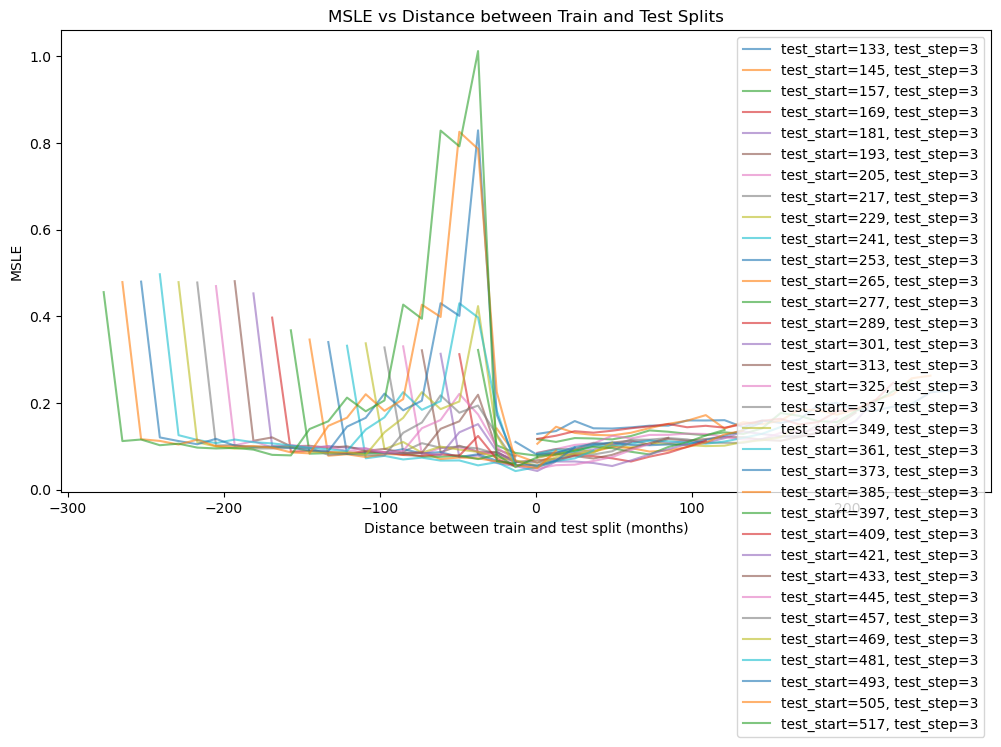

In [119]:
# plot mse and msle against distance, grouped by test_start
import matplotlib.pyplot as plt

step = 6
start = 325
plt.figure(figsize=(12, 6))
for (test_start, test_step), group in metrics_df.groupby(["test_start", "test_step"]):
    if test_step == 3:
        plt.plot(group["distance_adjusted"], group["msle"], label=f"test_start={test_start}, test_step={test_step}", alpha=0.6)
plt.xlabel("Distance between train and test split (months)")
plt.ylabel("MSLE")
plt.title("MSLE vs Distance between Train and Test Splits")
plt.legend()
plt.show()

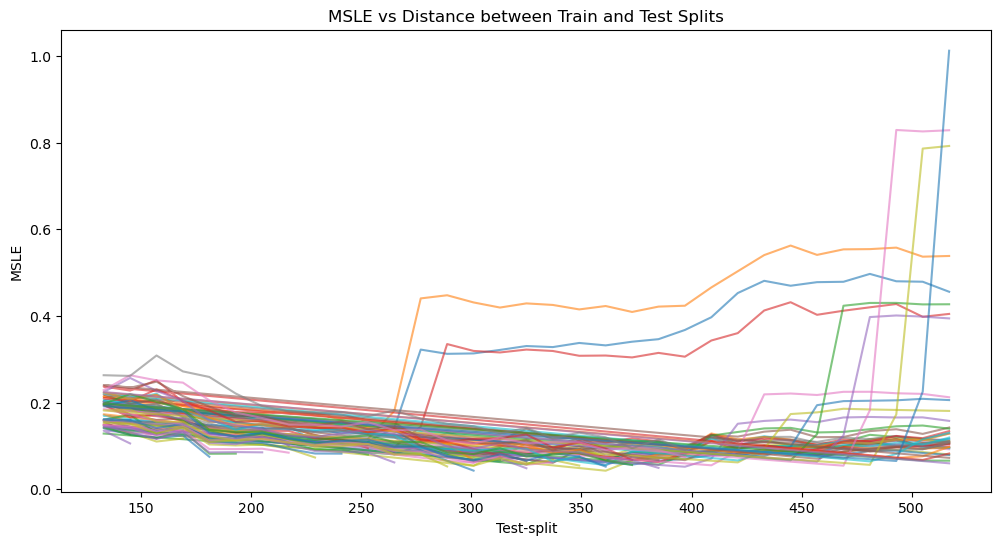

In [108]:
# plot mse and msle against distance, grouped by test_start
import matplotlib.pyplot as plt

step = 6
start = 325
plt.figure(figsize=(12, 6))
for (test_start, test_step), group in metrics_df.groupby(["train_start", "test_step"]):
        plt.plot(group["test_start"], group["msle"], label=f"test_start={test_start}, test_step={test_step}", alpha=0.6)
plt.xlabel("Test-split")
plt.ylabel("MSLE")
plt.title("MSLE vs Distance between Train and Test Splits")
#plt.legend()
plt.show()

In [97]:
fat_model.models[(157, 3)].model.feature_importances_

array([0.26885477, 0.31272984, 0.02126259, 0.00873937, 0.00967188,
       0.00860965, 0.0037295 , 0.01436223, 0.00893036, 0.00617112,
       0.00946849, 0.01065429, 0.00628087, 0.00600995, 0.00564827,
       0.00600887, 0.00414593, 0.03643375, 0.05163382, 0.00595817,
       0.00739606, 0.01178269, 0.00635136, 0.00657065, 0.04317705,
       0.02285385, 0.01697297, 0.03908776, 0.01686118, 0.0236427 ])

In [98]:
metrics_df[metrics_df["test_start"] == 325]

,train_start,train_end,train_step,test_start,test_end,test_step,mse,msle,distance,distance_adjusted
6,133,252,3,325,337,3,1.107578,0.330633,-144.5,-85.0
29,145,264,3,325,337,3,0.401582,0.080679,-132.5,-73.0
52,157,276,3,325,337,3,0.447491,0.096058,-120.5,-61.0
75,169,288,3,325,337,3,0.527264,0.097140,-108.5,-49.0
98,181,300,3,325,337,3,0.382063,0.087992,-96.5,-37.0
121,193,312,3,325,337,3,0.372809,0.079928,-84.5,-25.0
144,205,324,3,325,337,3,0.296178,0.057232,-72.5,-13.0
391,337,456,3,325,336,3,0.246041,0.048439,60.5,1.0
415,349,468,3,325,336,3,0.276543,0.056354,72.5,13.0
439,361,480,3,325,336,3,0.281151,0.057595,84.5,25.0


In [76]:
metrics_df["distance"]

0      -72.5
1      -84.5
2      -96.5
3     -108.5
4     -120.5
       ...  
595    288.5
596    300.5
597    312.5
598    324.5
599    336.5
Name: distance, Length: 600, dtype: float64

In [82]:
metrics_df.head()

,train_start,train_end,train_step,test_start,test_end,test_step,mse,msle,distance,distance_adjusted
0,122,241,1,242,254,1,0.505496,0.070219,-72.5,-13.0
1,122,241,1,254,266,1,0.488607,0.068490,-84.5,-25.0
2,122,241,1,266,278,1,0.406473,0.059871,-96.5,-37.0
3,122,241,1,278,290,1,0.363424,0.056318,-108.5,-49.0
4,122,241,1,290,302,1,0.315090,0.049421,-120.5,-61.0


## Debug

In [36]:
fat_data.head()

,month_id,country_id,ln_ged_sb_dep,gleditsch_ward,ln_ged_sb,reign_tenure_months,wdi_sp_pop_totl,wdi_ag_lnd_frst_k2,wdi_nv_agr_totl_kn,wdi_sh_sta_maln_zs,...,splag_vdem_v2xpe_exlsocgr,splag_vdem_v2xcl_rol,decay_ged_sb_5,decay_ged_os_5,decay_acled_os_5,decay_ged_sb_100,decay_ged_sb_500,splag_1_decay_ged_sb_5,target_month_id,target
0,1,1,0.0,110,0.0,165.0,774367.0,186021.5,1.297711e+11,13.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
1,1,2,0.0,115,0.0,51.0,375377.0,153776.3,1.084614e+09,11.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
2,1,3,0.0,52,0.0,210.0,1121744.0,2420.6,1.010259e+09,4.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
3,1,4,0.0,101,0.0,11.0,15258218.0,520260.0,1.283420e+09,3.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
4,1,5,0.0,990,0.0,47.0,164322.0,1761.3,2.391774e+08,1.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0


In [32]:
fat_data["target_month_id"] = fat_data["month_id"] + 2
fat_data["target"] = fat_data.groupby("country_id")["ln_ged_sb"].shift(-2)

In [35]:
fat_data[["country_id", "month_id", "target_month_id", "target", "ln_ged_sb"]].head(-100)

,country_id,month_id,target_month_id,target,ln_ged_sb
0,1,1,3,0.0,0.0
1,2,1,3,0.0,0.0
2,3,1,3,0.0,0.0
3,4,1,3,0.0,0.0
4,5,1,3,0.0,0.0
...,...,...,...,...,...
158125,99,852,854,NaN,0.0
158126,100,852,854,NaN,0.0
158127,101,852,854,NaN,0.0
158128,102,852,854,NaN,0.0
